# DEMetropolis(Z): Population vs. History efficiency comparison
The idea behind `DEMetropolis` is quite simple: Over time, a population of MCMC chains converges to the posterior, therefore the population can be used to inform joint proposals.
But just like the most recent positions of an entire population converges, so does the history of each individual chain.

In [ter Braak & Vrugt, 2008](https://doi.org/10.1007/s11222-008-9104-9) this history of posterior samples is used in the "DE-MCMC-Z" variant to make proposals.

The implementation in PyMC3 is based on `DE-MCMC-Z`, but a few details are different. Namely, each `DEMetropolisZ` chain only looks into its own history. Also we use a different tuning scheme.

In this notebook, a D-dimenstional multivariate normal target densities are sampled with `DEMetropolis` and `DEMetropolisZ` at different $N_{chains}$ settings.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import pathlib
import ipywidgets
import time
import fastprogress
import pymc3 as pm
import arviz as az

## Benchmarking with a D-dimensional MVNormal model
The function below constructs a fresh model for a given dimensionality and runs either `DEMetropolis` or `DEMetropolisZ` with the given settings. The resulting trace is saved with ArviZ.

If the saved trace is already found, it is loaded from disk.

Note that all traces are sampled with `cores=1`. This is because parallelization of `DEMetropolis` chains is slow at $O(N_{chains})$ and the comparison would be different depending on the number of available CPUs.

In [2]:
def get_mvnormal_model(D:int) -> pm.Model:
    true_mu = np.zeros(D)
    true_cov = np.eye(D)
    true_cov[:5,:5] = np.array([
        [1, 0.5, 0, 0, 0],
        [0.5, 2, 2, 0, 0],
        [0, 2, 3, 0, 0],
        [0, 0, 0, 4, 4],
        [0, 0, 0, 4, 5],
    ])

    with pm.Model() as pmodel:
        x = pm.MvNormal('x', mu=true_mu, cov=true_cov, shape=(D,))
    
    true_samples = x.random(size=1000)
    truth_id = arviz.data.convert_to_inference_data(true_samples[np.newaxis,:], group='random')
    return pmodel, truth_id

def run_setting(D, N_tune, N_draws, N_chains, algorithm):
    savename = f'{algorithm}_{D}_{N_tune}_{N_draws}_{N_chains}.nc'
    print(f'Scenario filename: {savename}')
    if not pathlib.Path(savename).exists():
        pmodel, truth_id = get_mvnormal_model(D)
        with pmodel:
            if algorithm == 'DE-MCMC':
                step = pm.DEMetropolis()
            elif algorithm == 'DE-MCMC-Z':
                step = pm.DEMetropolisZ()
            t_start = time.time()
            trace = pm.sample(
                cores=1, tune=N_tune, draws=N_draws, chains=N_chains,
                step=step,
                start={'x': [0]*D},
                discard_tuned_samples=False
            )
            t = time.time() - t_start
        trace = az.from_pymc3(trace)
        trace.sample_stats.attrs['t_sampling'] = t
        trace.to_netcdf(savename)
    else:
        trace = az.from_netcdf(savename)
        t = float(trace.sample_stats.t_sampling)
    return t, trace

## Running the Benchmark Scenarios
Here a variety of different scenarios is computed and the results are aggregated in a multi-indexed DataFrame.

In [3]:
df_results = pd.DataFrame(columns='algorithm,D,N_tune,N_draws,N_chains,t,trace'.split(','))
df_results = df_results.set_index('algorithm,D,N_tune,N_draws,N_chains'.split(','))

for algorithm in {'DE-MCMC', 'DE-MCMC-Z'}:
    for D in (10, 20, 40):
        N_tune = 10000
        N_draws = 10000
        for N_chains in (5,10,20,30,40,80):
            t, trace = run_setting(D, N_tune, N_draws, N_chains, algorithm)
            df_results.loc[(algorithm, D, N_tune, N_draws, N_chains)] = (t, trace)

Scenario filename: DE-MCMC-Z_10_10000_10000_5.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_10.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_20.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_30.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_40.nc
Scenario filename: DE-MCMC-Z_10_10000_10000_80.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_5.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_10.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_20.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_30.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_40.nc
Scenario filename: DE-MCMC-Z_20_10000_10000_80.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_5.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_10.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_20.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_30.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_40.nc
Scenario filename: DE-MCMC-Z_40_10000_10000_80.nc
Scenario filename: DE-MCMC_10_10000_10000_5.nc
Scenario filename: DE-MCMC_10_10000_10000_10.nc
Scenario

In [4]:
df_results

t  \
algorithm D  N_tune N_draws N_chains                
DE-MCMC-Z 10 10000  10000   5           71.638503   
                            10         144.084210   
                            20         294.116530   
                            30         425.120003   
                            40         559.172671   
                            80        1115.444842   
          20 10000  10000   5           72.920019   
                            10         145.833869   
                            20         284.143804   
                            30         430.893903   
                            40         574.449718   
                            80        1163.454674   
          40 10000  10000   5           75.096776   
                            10         159.661833   
                            20         329.414084   
                            30         474.857136   
                            40         646.029423   
                            80        1377.775875   
DE-MCMC   10 10000  10000   5           71.592606   
                            10         137.353182   
                            20         276.090765   
                            30         414.004901   
                            40         553.609195   
                            80        1123.000902   
          20 10000  10000   5           73.768358   
                            10         145.487072   
                            20         288.841047   
                            30         431.470670   
                            40         554.470461   
                            80        1127.241532   
          40 10000  10000   5           75.026569   
                            10         146.595495   
                            20         292.587237   
                            30         439.095635   
                            40         583.402438   
                            80        1213.149816   

                                                                                  trace  
algorithm D  N_tune N_draws N_chains                                                     
DE-MCMC-Z 10 10000  10000   5         Inference data with groups:\n\t> posterior\n\t...  
                            10        Inference data with groups:\n\t> posterior\n\t...  
                            20        Inference data with groups:\n\t> posterior\n\t...  
                            30        Inference data with groups:\n\t> posterior\n\t...  
                            40        Inference data with groups:\n\t> posterior\n\t...  
                            80        Inference data with groups:\n\t> posterior\n\t...  
          20 10000  10000   5         Inference data with groups:\n\t> posterior\n\t...  
                            10        Inference data with groups:\n\t> posterior\n\t...  
                            20        Inference data with groups:\n\t> posterior\n\t...  
                            30        Inference data with groups:\n\t> posterior\n\t...  
                            40        Inference data with groups:\n\t> posterior\n\t...  
                            80        Inference data with groups:\n\t> posterior\n\t...  
          40 10000  10000   5         Inference data with groups:\n\t> posterior\n\t...  
                            10        Inference data with groups:\n\t> posterior\n\t...  
                            20        Inference data with groups:\n\t> posterior\n\t...  
                            30        Inference data with groups:\n\t> posterior\n\t...  
                            40        Inference data with groups:\n\t> posterior\n\t...  
                            80        Inference data with groups:\n\t> posterior\n\t...  
DE-MCMC   10 10000  10000   5         Inference data with groups:\n\t> posterior\n\t...  
                            10        Inference data with groups:\n\t> posterior\n\t...  
                            20        Inference data 

## Analyzing the traces
From the traces, we need to compute the absolute and relative $N_{eff}$ and the $\hat{R}$ to see if we can trust the posteriors.

In [6]:
df_temp = df_results.reset_index(['N_tune', 'N_draws'])
df_temp['trace'] = [
    az.from_pymc3(trace) if isinstance(trace, pm.backends.base.MultiTrace) else trace
    for trace in df_temp.trace
]
df_temp['N_samples'] = [
    row.N_draws * row.Index[2]
    for row in df_temp.itertuples()
]
df_temp['ess'] = [
    float(az.ess({
        k : v[:,N_tune:,:]
        for k, v in row.trace.posterior.items()
    }).x.mean())
    for row in fastprogress.progress_bar(list(df_temp.itertuples()))
]
df_temp['rel_ess'] = [
    row.ess / (row.N_samples)
    for row in df_temp.itertuples()
]
df_temp['r_hat'] = [
    float(az.rhat({
        k : v[:,N_tune:,:]
        for k, v in trace.posterior.items()
    }).x.mean())
    for trace in fastprogress.progress_bar(df_temp.trace)
]
df_temp = df_temp.sort_index(level=['algorithm', 'D', 'N_chains'])

In [7]:
df_temp

N_tune  N_draws            t  \
algorithm D  N_chains                                 
DE-MCMC   10 5          10000    10000    71.592606   
             10         10000    10000   137.353182   
             20         10000    10000   276.090765   
             30         10000    10000   414.004901   
             40         10000    10000   553.609195   
             80         10000    10000  1123.000902   
          20 5          10000    10000    73.768358   
             10         10000    10000   145.487072   
             20         10000    10000   288.841047   
             30         10000    10000   431.470670   
             40         10000    10000   554.470461   
             80         10000    10000  1127.241532   
          40 5          10000    10000    75.026569   
             10         10000    10000   146.595495   
             20         10000    10000   292.587237   
             30         10000    10000   439.095635   
             40         10000    10000   583.402438   
             80         10000    10000  1213.149816   
DE-MCMC-Z 10 5          10000    10000    71.638503   
             10         10000    10000   144.084210   
             20         10000    10000   294.116530   
             30         10000    10000   425.120003   
             40         10000    10000   559.172671   
             80         10000    10000  1115.444842   
          20 5          10000    10000    72.920019   
             10         10000    10000   145.833869   
             20         10000    10000   284.143804   
             30         10000    10000   430.893903   
             40         10000    10000   574.449718   
             80         10000    10000  1163.454674   
          40 5          10000    10000    75.096776   
             10         10000    10000   159.661833   
             20         10000    10000   329.414084   
             30         10000    10000   474.857136   
             40         10000    10000   646.029423   
             80         10000    10000  1377.775875   

                                                                   trace  \
algorithm D  N_chains                                                      
DE-MCMC   10 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t...   
          20 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t...   
          40 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference data with groups:\n\t> posterior\n\t...   
DE-MCMC-Z 10 5         Inference data with groups:\n\t> posterior\n\t...   
             10        Inference data with groups:\n\t> posterior\n\t...   
             20        Inference data with groups:\n\t> posterior\n\t...   
             30        Inference data with groups:\n\t> posterior\n\t...   
             40        Inference data with groups:\n\t> posterior\n\t...   
             80        Inference

## Visualizing Effective Sample Size
In this diagram, we'll plot the relative effective sample size agains the number of chains.

Because our computation above ran everything with $N_{cores}=1$, we can't make a realistic comparison of effective sampling rates.

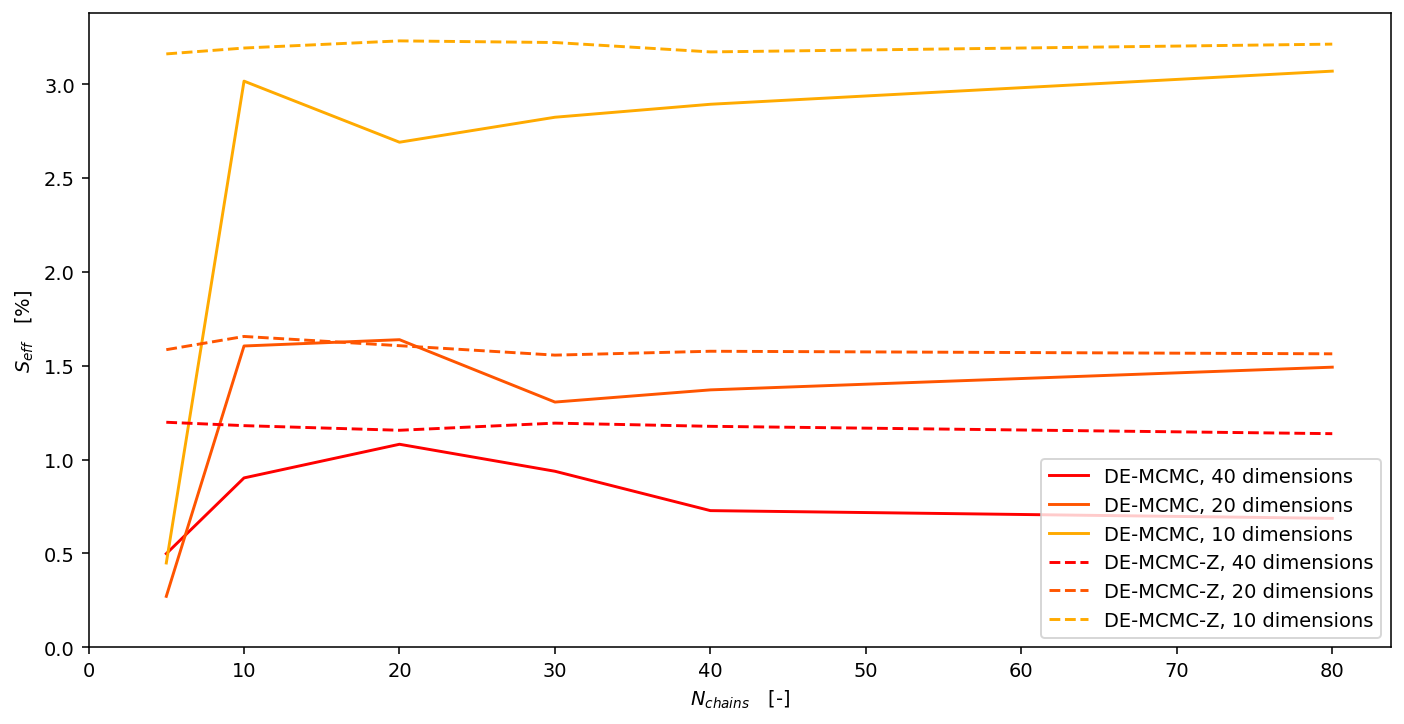

In [8]:
fig, right = plt.subplots(dpi=140, ncols=1, sharey='row', figsize=(12,6))

for algorithm, linestyle in zip(['DE-MCMC', 'DE-MCMC-Z'], ['-', '--']):
    dimensionalities = list(sorted(set(df_temp.reset_index().D)))[::-1]
    N_dimensionalities = len(dimensionalities)
    for d, dim in enumerate(dimensionalities):
        color = cm.autumn(d / N_dimensionalities)
        df = df_temp.loc[(algorithm, dim)].reset_index()
        right.plot(
            df.N_chains,
            df.rel_ess*100,
            linestyle=linestyle,
            color=color,
            label=f'{algorithm}, {dim} dimensions'
        )

right.legend()
right.set_ylabel('$S_{eff}$   [%]')
right.set_xlabel('$N_{chains}$   [-]')
right.set_ylim(0)
right.set_xlim(0)
plt.show()

## Visualizing Computation Time
As all traces were sampled with `cores=1`, we expect the computation time to grow linearly with the number of samples.

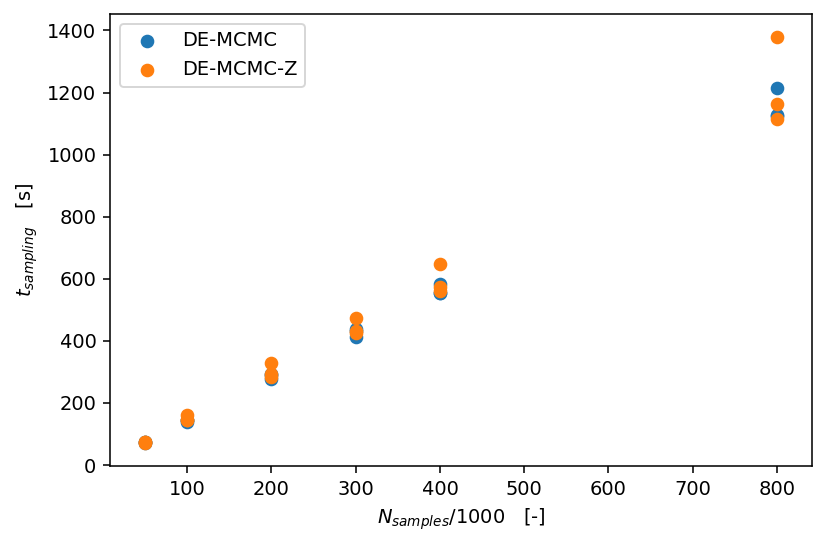

In [9]:
fig, ax = plt.subplots(dpi=140)

for alg in ['DE-MCMC', 'DE-MCMC-Z']:
    df = df_temp.sort_values('N_samples').loc[alg]
    ax.scatter(df.N_samples/1000, df.t, label=alg)
ax.legend()
ax.set_xlabel('$N_{samples} / 1000$   [-]')
ax.set_ylabel('$t_{sampling}$   [s]')
fig.tight_layout()
plt.show()

## Visualizing the Traces
By comparing DE-MCMC and DE-MCMC-Z for a setting such as D=10, $N_{chains}$=5, you can see how DE-MCMC-Z has a clear advantage over a DE-MCMC that is run with too few chains.

In [10]:
def plot_trace(algorithm, D, N_chains):
    n_plot = min(10, N_chains)
    fig, axs = plt.subplots(nrows=n_plot, figsize=(12,2*n_plot))
    trace = df_results.loc[(algorithm, D, 10000, 10000, N_chains), 'trace']
    for c in range(n_plot):
        samples = trace.posterior.x[c,:,0]
        axs[c].plot(samples, linewidth=0.5)
    plt.show();
    return

ipywidgets.interact_manual(
    plot_trace,
    algorithm=['DE-MCMC', 'DE-MCMC-Z'],
    D=sorted(set(df_results.reset_index().D)),
    N_chains=sorted(set(df_results.reset_index().N_chains)),
);

interactive(children=(Dropdown(description='algorithm', options=('DE-MCMC', 'DE-MCMC-Z'), value='DE-MCMC'), Dr…

## Inspecting the Sampler Stats
With the following widget, you can explore the sampler stats to better understand the tuning phase.

The `tune='lambda'` default setting of `DEMetropolisZ` improves the initial convergence by doing a swing-in that makes it diverge much faster than it would with a constant `lambda`. However, if the tuning is stopped too early, it can get stuck with a very inefficient `lambda`.

Therefore, you should always inspect the `lambda` and rolling mean of `accepted` sampler stats when picking $N_{tune}$.

In [11]:
def plot_stat(*, sname:str='accepted', rolling=True, algorithm, D, N_chains):
    fig, ax = plt.subplots(ncols=1, figsize=(12,7), sharey='row')
    row = df_results.loc[(algorithm, D, 10000, 10000, N_chains)]
    for c in df_results.trace[0].posterior.chain:
        S = row.trace.sample_stats[sname][0,:]
        y = pd.Series(S).rolling(window=500).mean().iloc[500-1:].values if rolling else S
        ax.plot(
            y,
            linewidth=0.5
        )
    ax.set_xlabel('iteration')
    ax.legend()
    ax.set_ylabel(sname)
    return

ipywidgets.interact_manual(
    plot_stat,
    sname=set(df_results.trace[0].sample_stats.keys()),
    rolling=True,
    algorithm=['DE-MCMC-Z','DE-MCMC'],
    D=sorted(set(df_results.reset_index().D)),
    N_chains=sorted(set(df_results.reset_index().N_chains)),
);

interactive(children=(Dropdown(description='sname', options=('accepted', 'scaling', 'accept', 'tune', 'lambda'…

## Conclusion
When used with the recommended settings, `DEMetropolis` is on par with `DEMetropolisZ`. On high-dimensional problems however, `DEMetropolisZ` can achieve the same effective sample sizes with less chains.

On problems where not enough CPUs are available to run $N_{chains}=2\cdot D$ `DEMetropolis` chains, the `DEMetropolisZ` should have much better scaling.